In [1]:
import os
import re
from dotenv import load_dotenv, find_dotenv
from pprint import pprint
import base64
import json
import mimetypes
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
## access to API key
notebook_directory = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images"

# Construct the absolute path to the api.env file
env_file_path = os.path.join(notebook_directory, "api.env")

# Load environment variables from the api.env file
load_dotenv(env_file_path, override=True)

# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

In [3]:
# !setx OPENAI_API_KEY api_key

os.environ['OPENAI_API_KEY'] = api_key

In [4]:
def encode_image(image_path: str):
    """Encodes an image to base64 and determines the correct MIME type."""
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        raise ValueError(f"Cannot determine MIME type for {image_path}")

    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return f"data:{mime_type};base64,{encoded_string}"


def create_payload(images: list[str], prompt: str, model="gpt-4-vision-preview", max_tokens=100, detail="high"):
    """Creates the payload for the API request."""
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        },
    ]

    for image in images:
        base64_image = encode_image(image)
        messages[0]["content"].append({
            "type": "image_url",
            "image_url": {
                "url": base64_image,
                "detail": detail,
            }
        })

    return {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens
    }


def query_openai(payload):
    """Sends a request to the OpenAI API and prints the response."""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

In [6]:
# Specify the path to dedupped_images
folder_path = "data/StanfordJpegs/dedupped_images"

# List all files in the folder
files_in_folder = os.listdir(folder_path)

# Create a list to store the paths of the JPEG images
image_paths = [os.path.join(folder_path, file) for file in files_in_folder if file.endswith('.jpg')]


In [7]:
selected_image_paths = image_paths[:10]

# Assuming image_paths is already populated
responses = []

prompt = '''Please describe this fashion item in detail. It is crucial that your description includes all of the following subcategories without missing any. Each subcategory should be addressed separately and in the order listed below:
 
- Specific Category: [Provide the specific type of item]
- Color: [Describe the color(s), including shade, undertones, intensity, and texture]
- Material: [Describe the material, including fabric type and weave if visible]
- Features: [Mention any notable features such as closures, pockets, or fit]
- Style: [Describe the style, including cut, fit, and intended wear]
- Occasion: [State the suitable occasion for wearing the item]

For example:
- Specific Category: Trousers
- Color: Bright cherry red with a matte finish, no patterns
- Material: Cotton twill
- Features: Four pockets, button closure with zipper, belt loops
- Style: Casual slim fit
- Occasion: Suitable for casual events and day-to-day wear

Your description should match this format and level of detail. Please ensure that each subcategory starts on a new line for clarity and that no subcategory is left unaddressed.
'''

for img_path in selected_image_paths:
    # Create payload for each image
    payload = create_payload([img_path], prompt)

    # Query the OpenAI API
    response = query_openai(payload)

    # Extract the relevant part of the response
    description = response['choices'][0]['message']['content']
    
    # Store the response and corresponding filename
    responses.append({
        "filename": os.path.basename(img_path),
        "description": description
    })

# Convert the responses list to a DataFrame
responses_df = pd.DataFrame(responses)

# Specify the filename
csv_filename = 'dedupped_descriptions.csv'

# Save to CSV
responses_df.to_csv(csv_filename, index=False)

In [8]:
# Print or process the responses
for item in responses[9:10]:
    print(f"Filename: {item['filename']}\nDescription: {item['description']}\n")

Filename: item106493588.jpg
Description: - Specific Category: Dress shirt
- Color: Classic white with a glossy finish, no visible patterns
- Material: Appears to be a blend of cotton and synthetic fibers, likely with a poplin weave given its smooth texture
- Features: Pointed collar, button front closure, long sleeves with button cuffs, no pocket, and darting for a tailored fit
- Style: Tailored fit with a formal design, intended to be tucked into trousers or skirts
- Occasion: Suitable for



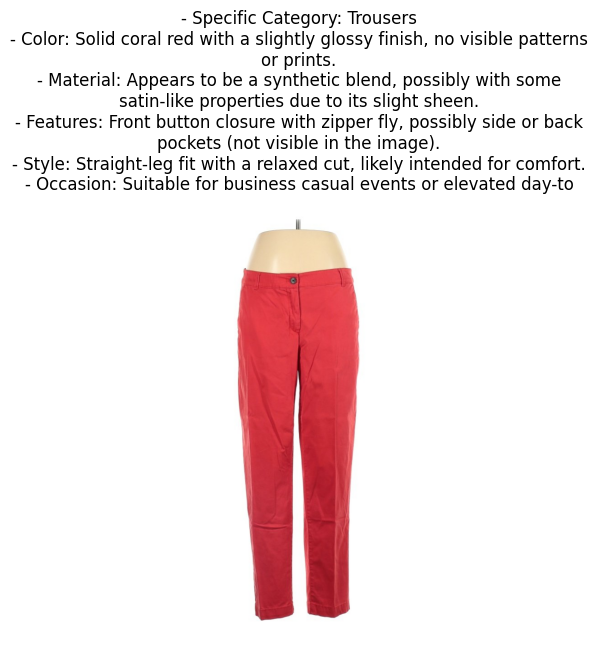

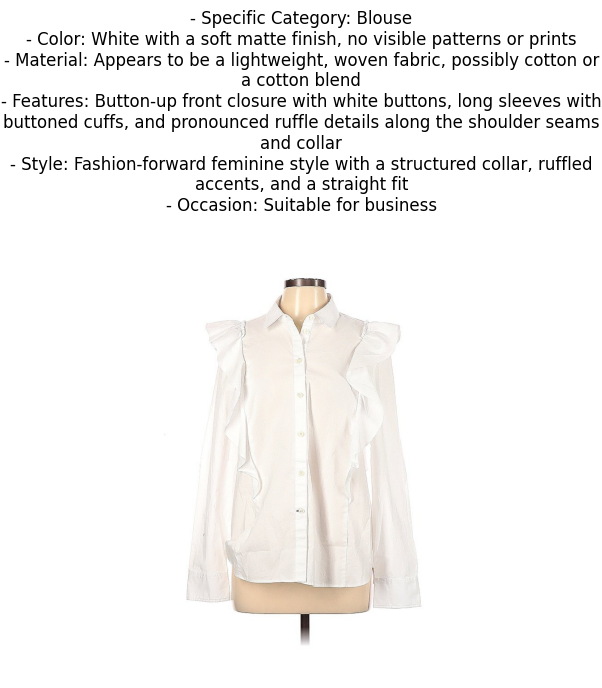

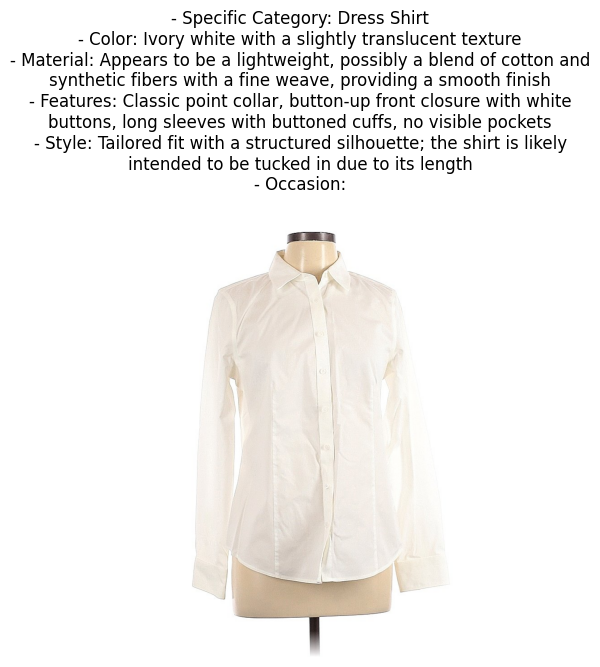

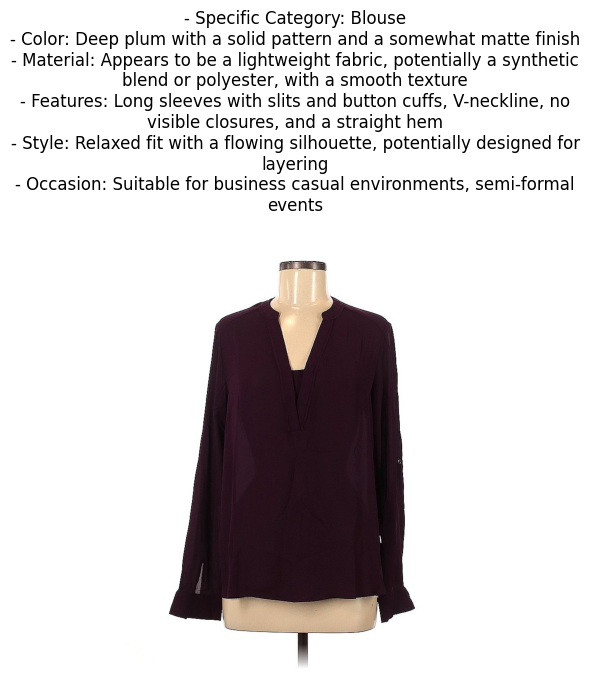

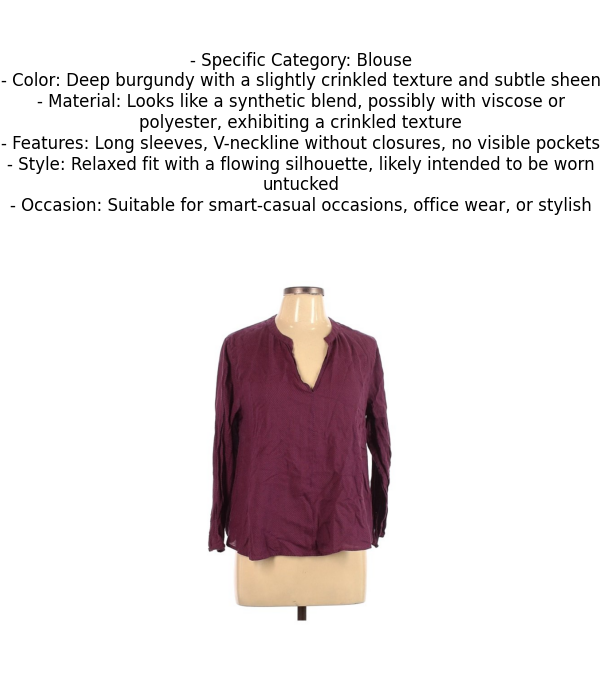

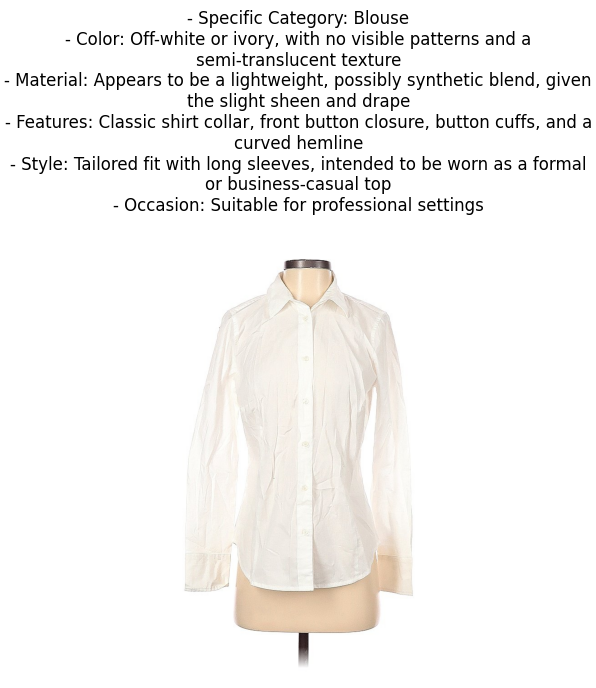

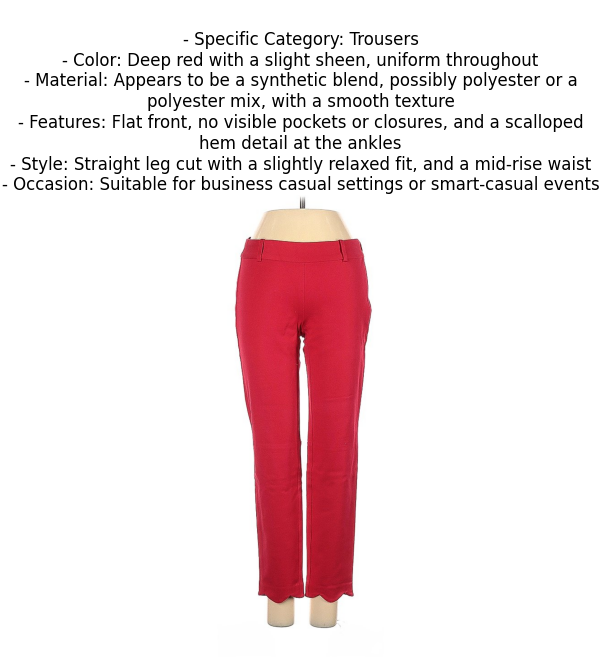

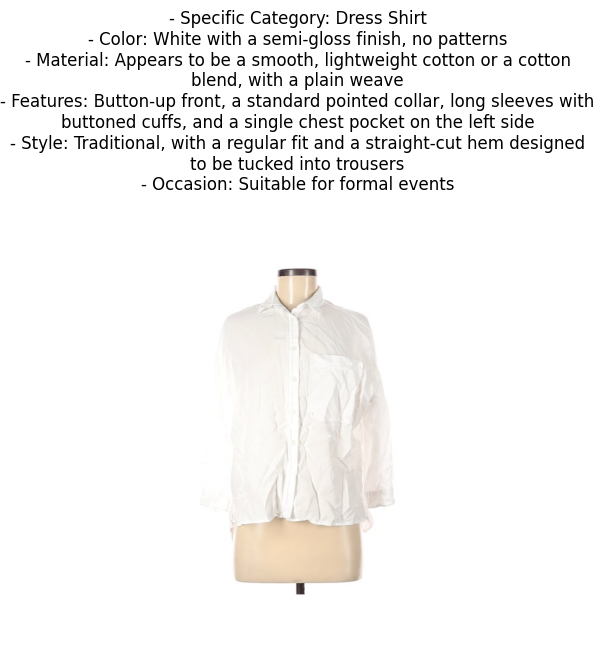

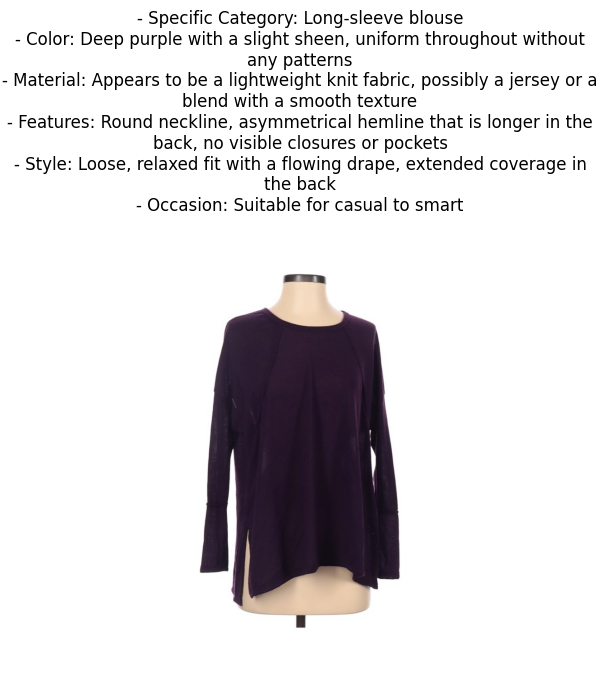

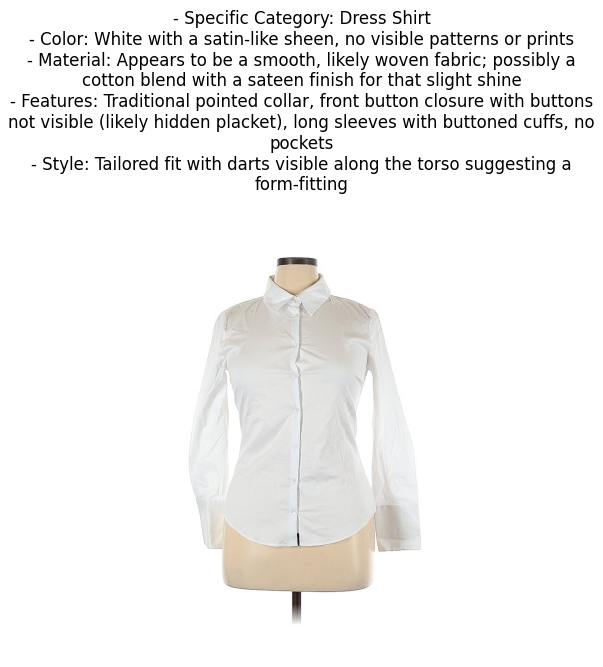

: 

In [15]:
#for visualizing data from csv files
captions_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/dedupped_descriptions3.csv"
captions = pd.read_csv(captions_path)
output_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/dedupped_images/"

# Iterate over the responses and display each image with its description
for item in range(10):
    
    img_path = os.path.join(output_dir, captions["filename"][item])
    
    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    plt.title(captions["description"][item], wrap=True)

    # Show the plot
    plt.show()

In [ ]:
# Base directory of your images
output_dir = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/StanfordJpegs/dedupped_images/"

# Iterate over the responses and display each image with its description
for item in responses[:10]:
    img_path = os.path.join(output_dir, item["filename"])

    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    plt.title(item["description"], wrap=True)

    # Show the plot
    plt.show()